# Predict on new data using a trained CNN on XPS data on Google Colab

In this notebook, we will use a trained convolutional network to predict on unseen XPS spectra.

## Setup

### Mount google drive, change working directory

In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')

# Change working path
os.chdir('/content/drive/My Drive/deepxps')

Mounted at /content/drive


### Install packages and import modules

In [2]:
%%capture
# Install packages
!pip install python-docx

# Import standard modules and magic commands
import datetime
import numpy as np
import pytz
import importlib
import matplotlib.pyplot as plt

# Magic commands
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

### Check TensorFlow version

In [3]:
tf.__version__

'2.4.1'

## Predict on new data set

### Load custom modules

In [4]:
try:
    import importlib
    importlib.reload(classifier)
    importlib.reload(clfutils)
    print('\n Modules were reloaded.')
except:
    import xpsdeeplearning.network.classifier as classifier
    import xpsdeeplearning.network.utils as clfutils
    print('Modules were loaded.')

Modules were loaded.


### Set up the parameters & folder structure

In [5]:
np.random.seed(502)
time = datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
exp_name = 'Fe_unscattered_4_classes_linear_comb_5eV_continuation_predict_using_20210318_22h48m'

clf = classifier.Classifier(time = time,
                            exp_name = exp_name,
                            task = 'regression',
                            intensity_only = True)

Model folder created at /saved_models/20210427_13h11m_Fe_unscattered_4_classes_linear_comb_5eV_continuation_predict_using_20210318_22h48m
Logs folder created at /logs/20210427_13h11m_Fe_unscattered_4_classes_linear_comb_5eV_continuation_predict_using_20210318_22h48m
Figures folder created at /figures/20210427_13h11m_Fe_unscattered_4_classes_linear_comb_5eV_continuation_predict_using_20210318_22h48m


### Load and inspect the data

Data was loaded!
Total no. of samples: 100000
No. of training samples: 1000
No. of validation samples: 0
No. of test samples: 99000
Shape of each sample : 1121 features (X) + 4 labels (y)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


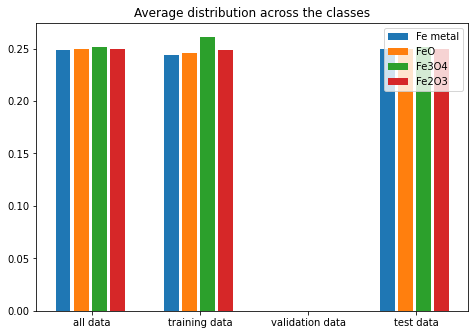

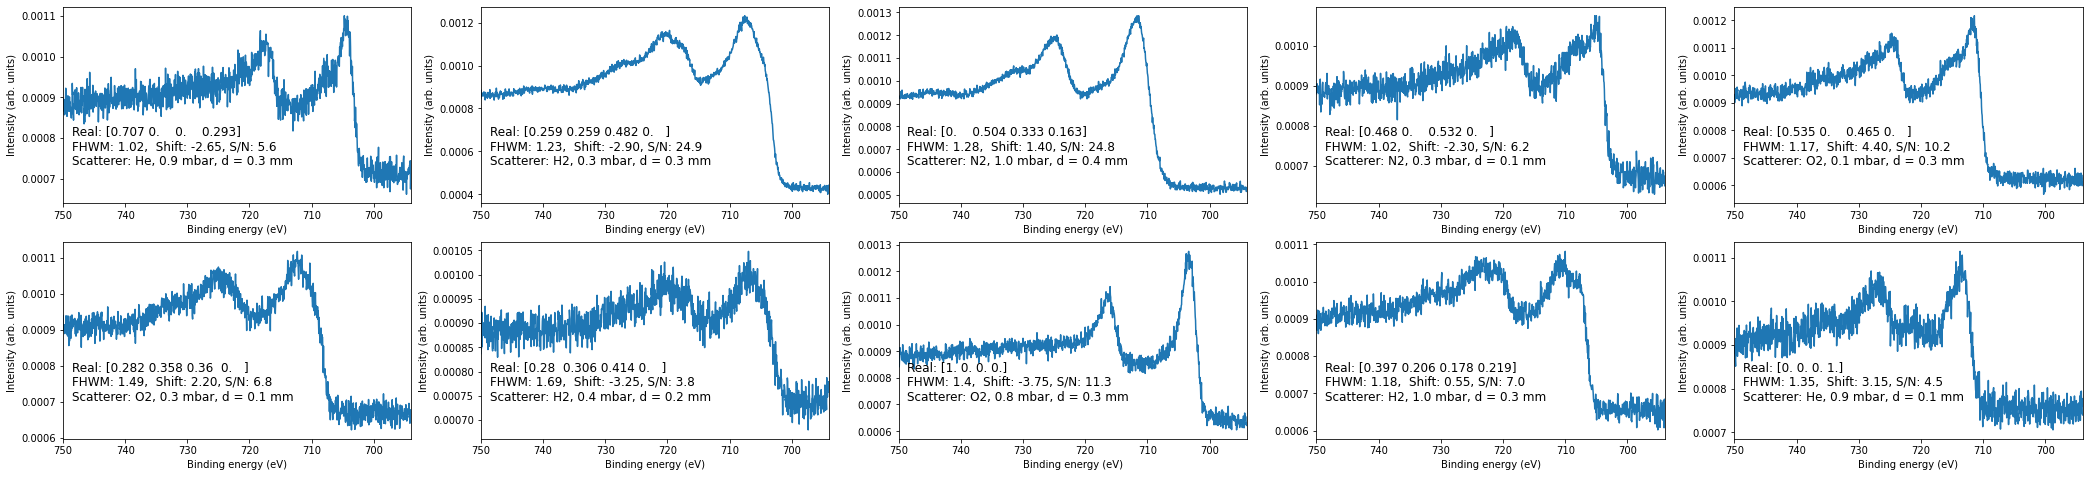

In [6]:
input_filepath = r'/content/drive/My Drive/deepxps/datasets/20210315_Fe_unscattered_linear_combination_small_gas_phase.h5'

train_test_split = 0.99
train_val_split = 0
no_of_examples = 100000 #180

        
X_train, X_val, X_test, y_train, y_val, y_test,\
    names_train, names_val, names_test =\
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.datahandler.check_class_distribution(clf.task)
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 10, dataset = 'test')  

### Continue with 10-point average of last values (cutoff: 5 eV on each side)

In [26]:
for dataset in [clf.datahandler.X,
                clf.datahandler.X_train,
                clf.datahandler.X_val,
                clf.datahandler.X_test]:
    for arr in dataset:
        arr[:100,:] = np.average(arr[100:110,:],
                                 axis=0)
        arr[-100:,:] = np.average(arr[-110:-100,:],
                                  axis=0)

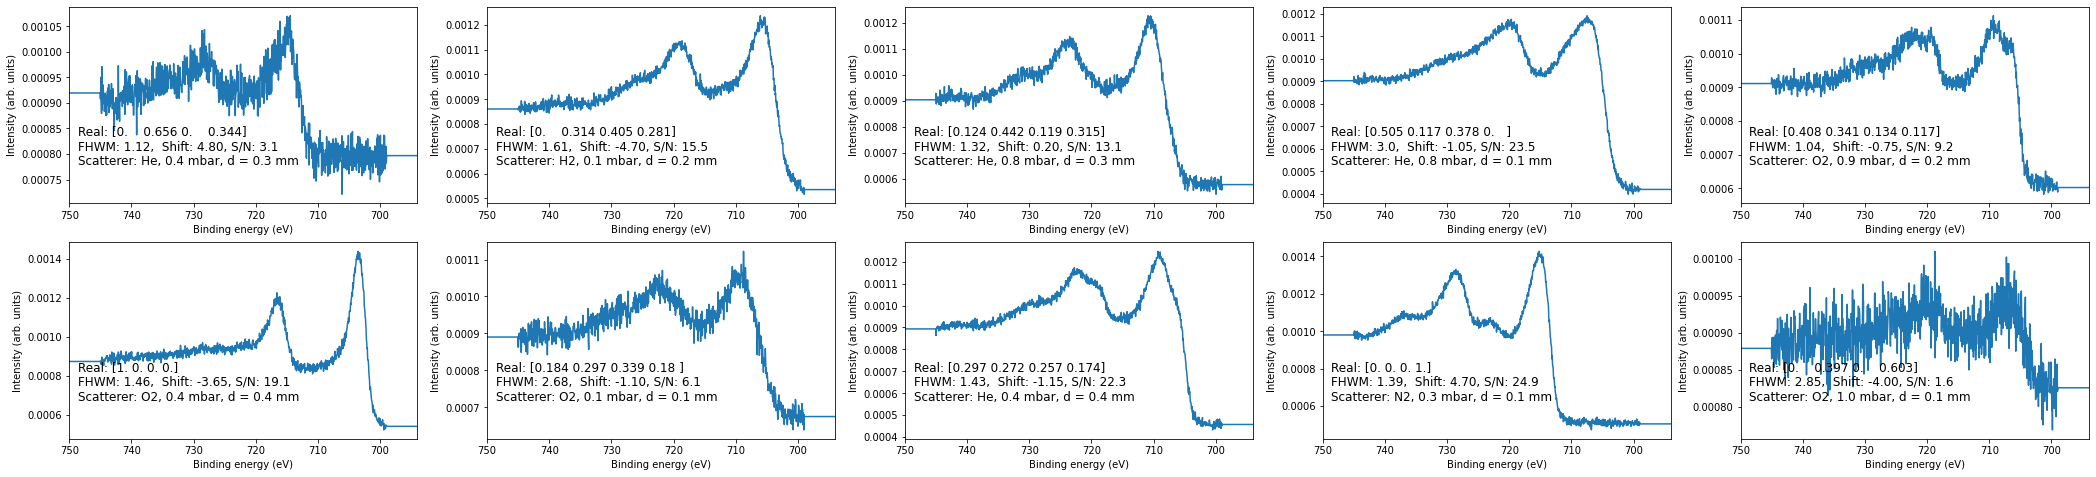

In [28]:
clf.plot_random(no_of_spectra = 10, dataset = 'test')  

### Load and compile the model

In [29]:
clf.load_model(model_path = '/content/drive/My Drive/deepxps/saved_models/20210318_22h48m_Fe_unscattered_4_classes_linear_comb_small_gas_phase',
               compile_model = True)

Loaded model from disk.


### Plot summary and save model plot.


Model: "Loaded_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1121, 1)]    0                                            
__________________________________________________________________________________________________
conv_1_short (Conv1D)           (None, 1121, 12)     72          input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_medium (Conv1D)          (None, 1121, 12)     132         input_1[0][0]                    
__________________________________________________________________________________________________
conv_1_long (Conv1D)            (None, 1121, 12)     192         input_1[0][0]                    
_______________________________________________________________________________________

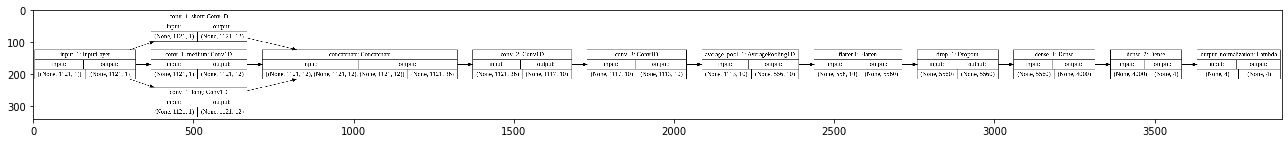

In [23]:
clf.summary()
clf.save_and_print_model_image()

### Evaluate on test data

In [24]:
clf.logging.hyperparams['batch_size'] = 32

if clf.task == 'classification':
    score = clf.evaluate()
    test_loss, test_accuracy = score[0], score[1]
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))
    print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))
elif clf.task == 'regression':
    test_loss = clf.evaluate()
    print('Test loss: ' + str(np.round(test_loss, decimals=8)))

3094/3094 [==============================] - 8s 3ms/step - loss: 0.0754
Evaluation done! 

Test loss: 0.0752496


###  Predict on train & test data

In [30]:
pred_train, pred_test = clf.predict()
if clf.task == 'classification':
    pred_train_classes, pred_test_classes = clf.predict_classes()

3094/3094 [==============================] - 7s 2ms/step
Prediction done!


### Show some predictions on random test samples

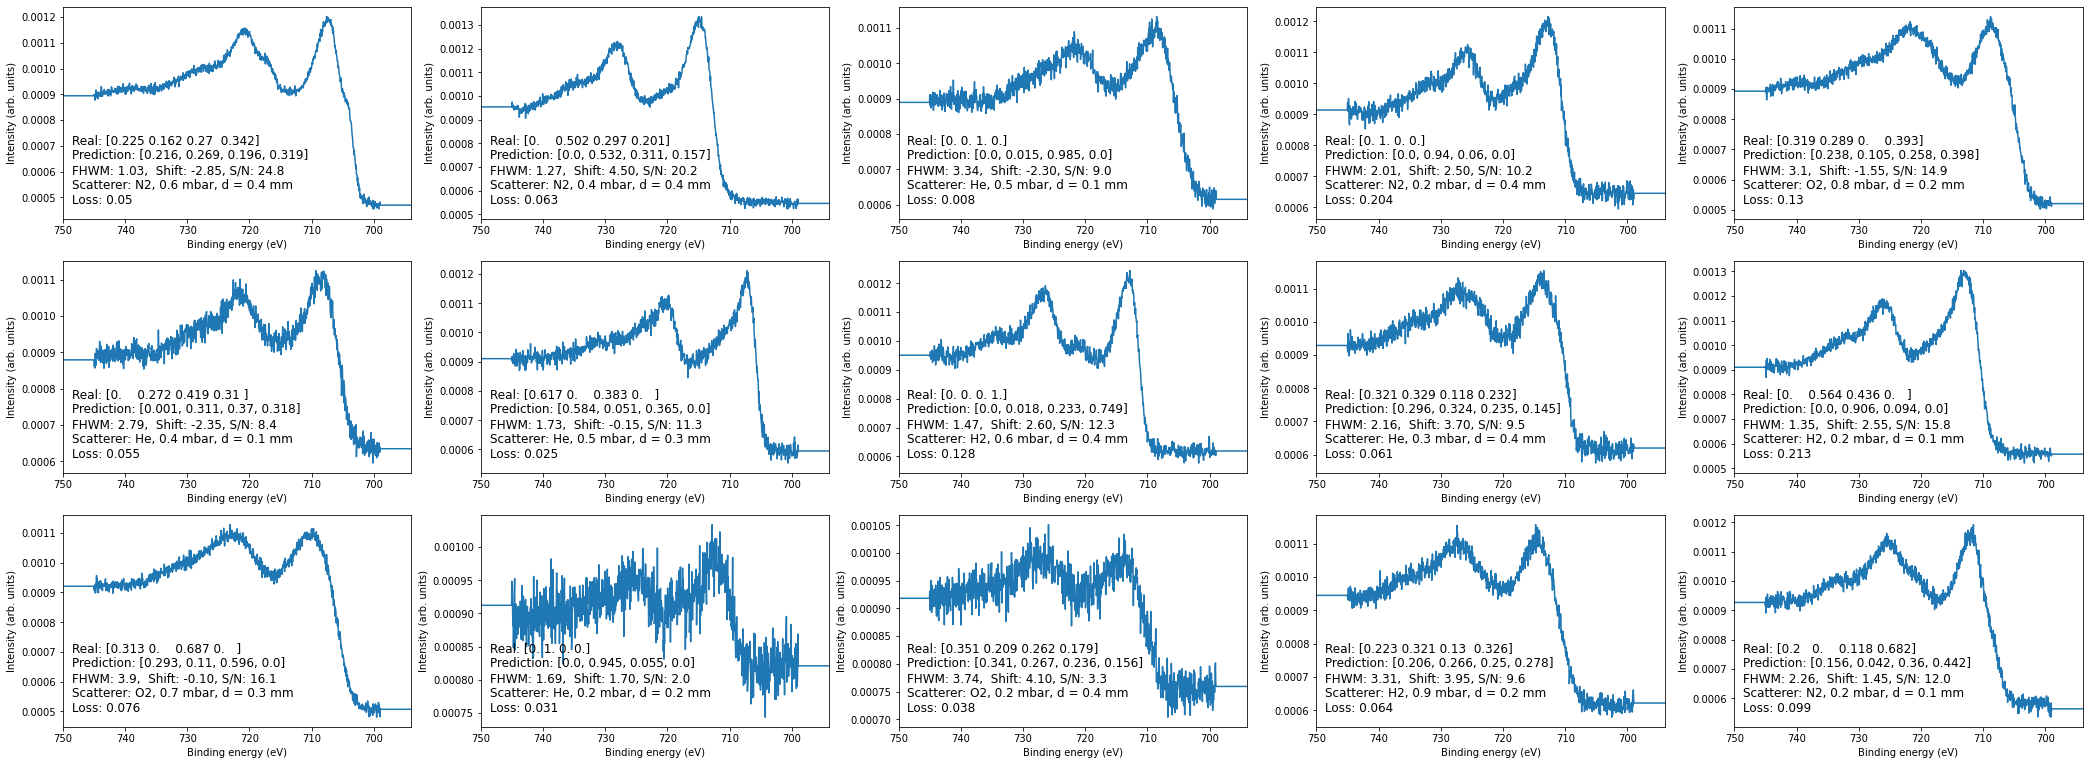

In [31]:
clf.plot_random(no_of_spectra = 15, dataset = 'test', with_prediction = True)  


### Show the worst predictions on the test samples

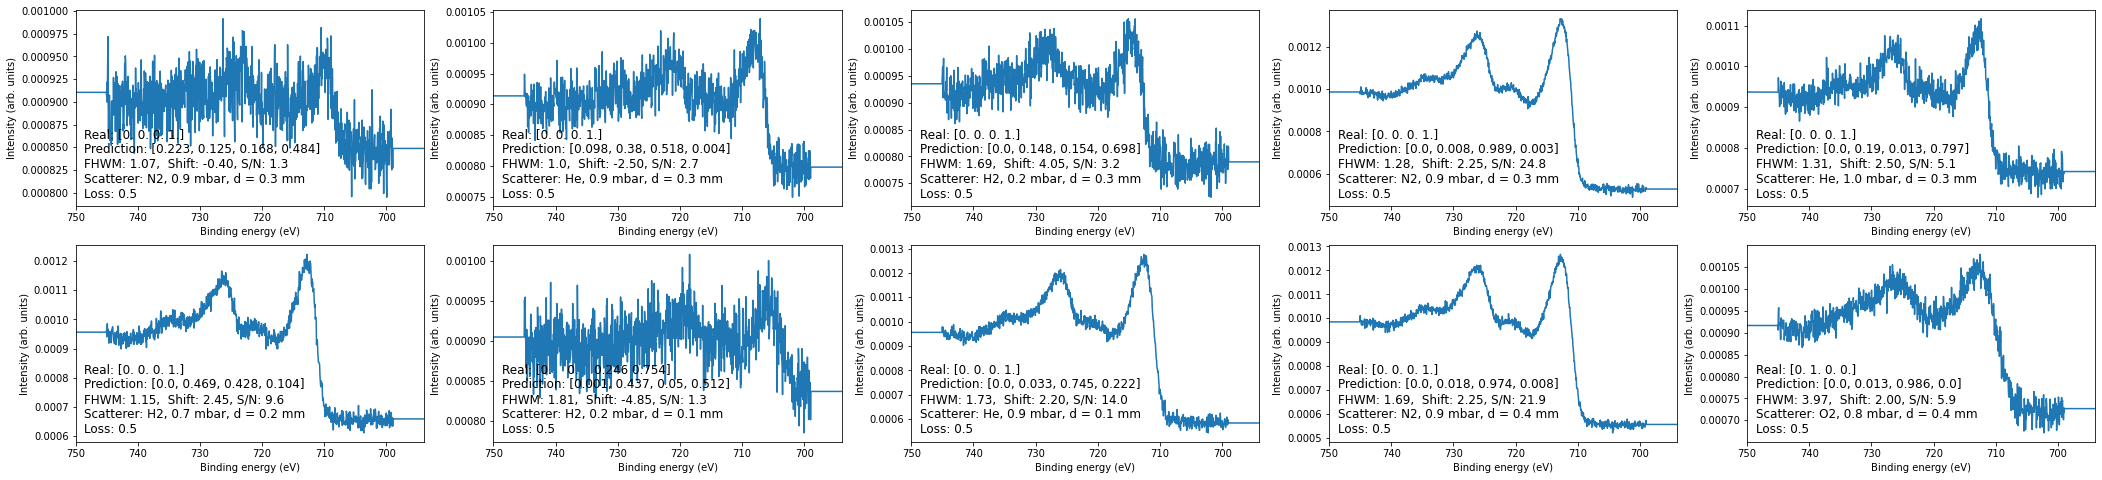

In [32]:
clf.show_worst_predictions(no_of_spectra = 10)

### Save data

In [33]:
#clf.save_hyperparams()
clf.pickle_results()

Saved results to file.


## Check where and why the predictions fail

### Show worst predictions for single spectra

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10, kind = 'single')

#### Show worst predictions for different loss thresholds (single spectra)


In [ ]:
threshold = 0.2
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.1
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.05
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.02
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

In [ ]:
threshold = 0.01
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'single',
                           threshold = threshold)

### Show worst predictions for linearly combined spectra

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb')

#### Show worst predictions for different loss thresholds (linearly combined spectra)

In [ ]:
threshold = 0.3
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.2
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.1
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.05
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.025
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.01
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

In [ ]:
threshold = 0.005
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'linear_comb',
                           threshold = threshold)

### Show worst predictions for all

In [ ]:
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all')

### Show worst predictions for different loss thresholds (all spectra)

In [ ]:
threshold = 0.3
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.2
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.1
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.05
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.025
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.01
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.005
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.001
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.0005
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.00025
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.0001
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

In [ ]:
threshold = 0.00001
clf.show_worst_predictions(no_of_spectra = 10,
                           kind = 'all',
                           threshold = threshold)

## Remove empty model directory

In [34]:
import shutil
shutil.rmtree(clf.logging.model_dir)

del(clf.logging.model_dir)

## Save output of notebook

In [35]:
from IPython.display import Javascript, display
from nbconvert import HTMLExporter

def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
            include=['application/javascript'])

def output_HTML(read_file, output_file):
    import codecs
    import nbformat
    exporter = HTMLExporter()
    # read_file is '.ipynb', output_file is '.html'
    output_notebook = nbformat.read(read_file, as_version=4)
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

import time
import os

time.sleep(20)
save_notebook()
print('Notebook saved!')
time.sleep(30)
current_file = '/content/drive/My Drive/deepxps/xpsdeeplearning/predict_unknown.ipynb'
output_file = os.path.join(clf.logging.log_dir,
                           'predict_unknown_out.html')
output_HTML(current_file, output_file)
print('HTML file saved!')

Notebook saved!
HTML file saved!
